In [45]:
import pandas as pd
import numpy as np
from gurobipy import Model, GRB
from gurobipy import quicksum
import gurobipy as gp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style ="whitegrid", font_scale=1.5)

In [46]:
DTLA = pd.read_csv('../input/schedule_5min_0612.csv').reset_index()
DTLA['schedule'] = np.ceil(DTLA['schedule']/5)
DTLA['origin'] = DTLA['od'].apply(lambda x: 0 if x.split('_')[0] == 'LAX' else 1)
DTLA['destination'] = DTLA['od'].apply(lambda x: 0 if x.split('_')[1] == 'LAX' else 1)

In [167]:
import src.topo
import importlib
importlib.reload(src.topo)
from src.topo import AssignmentNetwork, FlightTask, ChargingNetwork
from tqdm import tqdm
import pickle

In [168]:
vertiports = ['LAX', 'DTLA']

flight_time = np.array([[0,2,3,4,4],
                        [2,0,5,6,6],
                        [3,5,0,7,7],
                        [4,6,7,0,8],
                        [4,6,7,8,0]])

# Units for energy consumption is levels of %SoC
energy_consumption = np.array([[0,10,15,20,25],
                               [10,0,25,30,35],
                               [15,25,0,35,35],
                               [20,30,35,0,40],
                               [25,35,35,40,0]]) / 2.5
energy_consumption = energy_consumption.astype(int)

od_matrix = np.array([[0,1,1,1,1],
                      [1,0,1,1,1],
                      [1,1,0,1,1],
                      [1,1,1,0,1],
                      [1,1,1,1,0]])

flight_time = flight_time[:len(vertiports), :len(vertiports)]
energy_consumption = energy_consumption[:len(vertiports), :len(vertiports)]
od_matrix = od_matrix[:len(vertiports), :len(vertiports)]

In [235]:
network2 = ChargingNetwork(vertiports, flight_time, energy_consumption, od_matrix)
nodes, supply, edges, cost, c = network2.populate_network()

In [236]:
def obtain_demand_dict(df, existing_dict=None):
    if existing_dict is not None:
        demand_dict = existing_dict
    else:
        demand_dict = {}
        
    df_grouped = df.groupby(['origin', 'destination', 'schedule']).size().reset_index(name='count')
    for i, row in df_grouped.iterrows():
        demand_dict[(int(row['origin']), int(row['destination']), int(row['schedule']))] = int(row['count'])
    return demand_dict

In [237]:
od_key = {'LAX':0, 'DTLA':1}
flight_demand = obtain_demand_dict(DTLA)

In [52]:
m = Model("LagrangianRelaxation")
# Create variables
var_keys = m.addVars(edges, name=lambda e: f"flow_{e[0]}_{e[1]}", lb=0)
# Create flow conservation constraints
m.setParam('Threads', 4)
for n in tqdm(nodes):
    m.addConstr(quicksum(var_keys[i, j] for i, j in edges if j == n) -
    quicksum(var_keys[i, j] for i, j in edges if i == n) == supply.get(n, 0), f"node_{n}")
m.update()
m.write(f'../output/star_network/LR/two_vertiport.mps')

Set parameter Threads to value 4


  2%|▏         | 402/19142 [00:05<04:32, 68.87it/s]


KeyboardInterrupt: 

In [238]:
m = gp.read(f'../output/star_network/LR/two_vertiport.mps')
flow_vars = m.getVars()
flow = {edges[idx]: flow_vars[idx] for idx in range(len(flow_vars))}

Read MPS format model from file ../output/star_network/LR/two_vertiport.mps
Reading time = 0.09 seconds
LagrangianRelaxation: 19142 rows, 335739 columns, 671478 nonzeros


In [239]:
def get_flight_edges(i, model_param, flight_time=flight_time, energy_consumption=energy_consumption):
    K = 32
    v1, v2, t = i
    flight_time_ij = flight_time[v1, v2]
    soc_level_drop = int(energy_consumption[v1, v2])

    volume = quicksum(model_param[(v1, t, k), (v2, t+flight_time_ij, k-soc_level_drop)] for k in range(soc_level_drop, K+1))
    
    return volume
    

In [241]:
from time import time
from IPython.display import clear_output


def subgradient_descent_with_momentum(x_init, learning_rate, momentum, n_iterations):
    x = x_init
    v = 0  # Initialize momentum term
    for i in range(n_iterations):
        g = subgradient(x)
        v = momentum * v + learning_rate * g  # Update momentum
        x = x - v  # Update position
        print(f"Iteration {i+1}: x = {x}, objective = {objective_function(x)}")
    return x


def solve_lr(m, c, flow, edges, flight_demand, lambda_s, v, step_size):
    lambda_s0 = lambda_s.copy()

    primal_objective = quicksum(c[i,j] * flow[i,j] for i,j in edges)
    lagragian_dual_objective = quicksum(lambda_s[i] * (flight_demand[i]-get_flight_edges(i, flow)) for i in flight_demand.keys())
    

    m.setObjective(primal_objective + lagragian_dual_objective, GRB.MINIMIZE)
    m.update()
    m.optimize()

    subgradients = {i: flight_demand[i] - get_flight_edges(i, flow).getValue() for i in flight_demand.keys()}

    
    solution = m.getAttr('x', flow)
    flow_sum = sum(solution[i,j] for (i,j) in edges if i == 'Source' and j == 'Sink')

    primal_ofv = primal_objective.getValue()
    dual_ofv = lagragian_dual_objective.getValue()
    fleetsize = primal_ofv + dual_ofv


    # lambda_s[i] = max(0, lambda_s[i] + step_size * subgradients[i])

    for i in flight_demand.keys():
        o1, o2 = subgradient_descent_with_momentum(subgradients[i], v[i], lambda_s[i])
        lambda_s[i] = max(0, o1)
        v[i] = o2


    # Return primal and dual objective values, fleetsize, and flow sum, and updated lambda_s
    return primal_ofv, dual_ofv, fleetsize, flow_sum, lambda_s
    
def subgradient_descent_with_momentum(g, v, x, learning_rate=0.00001, momentum=0.2):
    v = momentum * v + learning_rate * g  # Update momentum
    x = x + v  # Update position

    return x, v

In [244]:
# lambda_s = {i: 0 for i in flight_demand.keys()}
# v = {i: 0 for i in flight_demand.keys()}
max_iter = 2000
# fs = [0]
step_size = 0.001
start_time = time()
for iteration in range(400, max_iter):

    m = gp.read(f'../output/star_network/LR/two_vertiport.mps')
    m.setParam('OutputFlag', 0)
    flow_vars = m.getVars()
    flow = {edges[idx]: flow_vars[idx] for idx in range(len(flow_vars))}
    
    primal_ofv, dual_ofv, fleetsize, flow_sum, lambda_s = solve_lr(m, c, flow, edges, flight_demand, lambda_s, v, step_size)


    print('------------Iteration {}------------'.format(iteration))
    print('Primal Objective: {}'.format(primal_ofv))
    print('Dual Objective: {}'.format(dual_ofv))
    print('Fleetsize: {}'.format(fleetsize))
    print('Flow Sum: {}'.format(flow_sum))
    print('Step Size: {}'.format(step_size))
    fs.append(fleetsize)


    if iteration % 20 == 0:
        print('Time Elapsed: {}'.format(time() - start_time))
        clear_output(wait=True)

Read MPS format model from file ../output/star_network/LR/two_vertiport.mps
Reading time = 0.07 seconds
LagrangianRelaxation: 19142 rows, 335739 columns, 671478 nonzeros
------------Iteration 1421------------
Primal Objective: 0.0
Dual Objective: 9.341113129377716
Fleetsize: 9.341113129377716
Flow Sum: 100.0
Step Size: 0.001
Read MPS format model from file ../output/star_network/LR/two_vertiport.mps
Reading time = 0.07 seconds
LagrangianRelaxation: 19142 rows, 335739 columns, 671478 nonzeros
------------Iteration 1422------------
Primal Objective: 0.0
Dual Objective: 9.359762625875625
Fleetsize: 9.359762625875625
Flow Sum: 100.0
Step Size: 0.001
Read MPS format model from file ../output/star_network/LR/two_vertiport.mps
Reading time = 0.07 seconds
LagrangianRelaxation: 19142 rows, 335739 columns, 671478 nonzeros
------------Iteration 1423------------
Primal Objective: 0.0
Dual Objective: 9.378642525175229
Fleetsize: 9.378642525175229
Flow Sum: 100.0
Step Size: 0.001
Read MPS format mod

KeyboardInterrupt: 

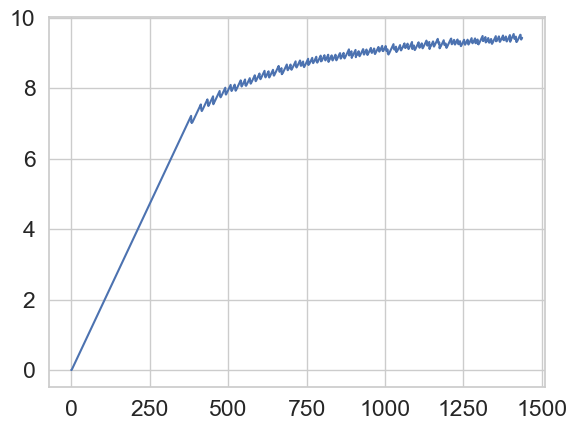

In [245]:
plt.plot(fs)

In [163]:
m = gp.read(f'../output/star_network/LR/two_vertiport.mps')
m.setParam('OutputFlag', 0)
flow_vars = m.getVars()
flow = {edges[idx]: flow_vars[idx] for idx in range(len(flow_vars))}
m.update()
get_flight_edges((0,1,3), flow)


Read MPS format model from file ../output/star_network/LR/two_vertiport.mps
Reading time = 0.07 seconds
LagrangianRelaxation: 19142 rows, 335739 columns, 671478 nonzeros


<gurobi.LinExpr: C319093(2) + C319094(2) + C319095(2) + C319096(2) + C319097(2) + C319098(2) + C319099(2) + C319100(2) + C319101(2) + C319102(2) + C319103(2) + C319104(2) + C319105(2) + C319106(2) + C319107(2) + C319108(2) + C319109(2) + C319110(2) + C319111(2) + C319112(2) + C319113(2) + C319114(2) + C319115(2) + C319116(2) + C319117(2) + C319118(2) + C319119(2) + C319120(2) + C319121(2)>

In [248]:
import pandas as pd

df = pd.read_csv('../DemandUncertainty/LAX_ind.csv')

In [250]:
df.iloc[:10, :].to_csv('LAX_ind.csv', index=False)

In [146]:
with open('mylist.txt', 'w') as f:
    for item in edges:
        f.write("%s\n" % str(item))

In [171]:
edges

[('Source', 'Sink'),
 ('Source', (0, 1, 0)),
 ('Source', (0, 1, 1)),
 ('Source', (0, 1, 2)),
 ('Source', (0, 1, 3)),
 ('Source', (0, 1, 4)),
 ('Source', (0, 1, 5)),
 ('Source', (0, 1, 6)),
 ('Source', (0, 1, 7)),
 ('Source', (0, 1, 8)),
 ('Source', (0, 1, 9)),
 ('Source', (0, 1, 10)),
 ('Source', (0, 1, 11)),
 ('Source', (0, 1, 12)),
 ('Source', (0, 1, 13)),
 ('Source', (0, 1, 14)),
 ('Source', (0, 1, 15)),
 ('Source', (0, 1, 16)),
 ('Source', (0, 1, 17)),
 ('Source', (0, 1, 18)),
 ('Source', (0, 1, 19)),
 ('Source', (0, 1, 20)),
 ('Source', (0, 1, 21)),
 ('Source', (0, 1, 22)),
 ('Source', (0, 1, 23)),
 ('Source', (0, 1, 24)),
 ('Source', (0, 1, 25)),
 ('Source', (0, 1, 26)),
 ('Source', (0, 1, 27)),
 ('Source', (0, 1, 28)),
 ('Source', (0, 1, 29)),
 ('Source', (0, 1, 30)),
 ('Source', (0, 1, 31)),
 ('Source', (0, 1, 32)),
 ('Source', (1, 1, 0)),
 ('Source', (1, 1, 1)),
 ('Source', (1, 1, 2)),
 ('Source', (1, 1, 3)),
 ('Source', (1, 1, 4)),
 ('Source', (1, 1, 5)),
 ('Source', (1, 1, 6

In [172]:
with open('mylist2.txt', 'w') as f:
    for item in edges:
        f.write("%s\n" % str(item))

In [207]:
first_10_step = {}
for k in flight_demand.keys():
    i,j,t = k
    if t <= 10:
        first_10_step[k] = flight_demand[k]
first_10_step

{(0, 1, 1): 1,
 (0, 1, 2): 1,
 (0, 1, 3): 1,
 (0, 1, 4): 1,
 (0, 1, 5): 1,
 (0, 1, 6): 1,
 (0, 1, 7): 1,
 (0, 1, 8): 1,
 (0, 1, 9): 1,
 (0, 1, 10): 2,
 (1, 0, 2): 1,
 (1, 0, 3): 1,
 (1, 0, 5): 1,
 (1, 0, 9): 1}

In [226]:
m = Model("LagrangianRelaxation")
# Create variables
var_keys = m.addVars(edges, name=lambda e: f"flow_{e[0]}_{e[1]}", lb=0)
# Create flow conservation constraints
m.setParam('outputflag', 0)
m.setParam('Threads', 4)
for n in tqdm(nodes):
    m.addConstr(quicksum(var_keys[i, j] for i, j in edges if j == n) -
    quicksum(var_keys[i, j] for i, j in edges if i == n) == supply.get(n, 0), f"node_{n}")
m.update()


100%|██████████| 4094/4094 [00:12<00:00, 324.21it/s]


In [227]:
for i in first_10_step.keys():
    m.addConstr(get_flight_edges(i, var_keys) >= flight_demand[i], name=f'demand_constraint_{i}')

In [228]:
objective = quicksum(c[i,j] * var_keys[i,j] for i,j in edges)
m.relax()
m.setObjective(objective, GRB.MINIMIZE)
m.optimize()
m.getObjective().getValue()

5.0

In [224]:
m = Model("LagrangianRelaxation")
# Create variables
var_keys = m.addVars(edges, name=lambda e: f"flow_{e[0]}_{e[1]}", lb=0)
# Create flow conservation constraints
m.setParam('outputflag', 0)
m.setParam('Threads', 4)
for n in tqdm(nodes):
    m.addConstr(quicksum(var_keys[i, j] for i, j in edges if j == n) -
    quicksum(var_keys[i, j] for i, j in edges if i == n) == supply.get(n, 0), f"node_{n}")
m.update()

lambda_s = {i: 0 for i in first_10_step.keys()}
v = {i: 0 for i in first_10_step.keys()}
max_iter = 3000
fs = [0]
step_size = 0.001
start_time = time()
for iteration in range(max_iter):
    
    primal_ofv, dual_ofv, fleetsize, flow_sum, lambda_s = solve_lr(m, c, var_keys, edges, first_10_step, lambda_s, v, step_size)

    print('------------Iteration {}------------'.format(iteration))
    print('Primal Objective: {}'.format(primal_ofv))
    print('Dual Objective: {}'.format(dual_ofv))
    print('Fleetsize: {}'.format(fleetsize))
    print('Flow Sum: {}'.format(flow_sum))
    print('Step Size: {}'.format(step_size))
    fs.append(fleetsize)


    if iteration % 20 == 0:
        print('Time Elapsed: {}'.format(time() - start_time))
        clear_output(wait=True)

KeyboardInterrupt: 

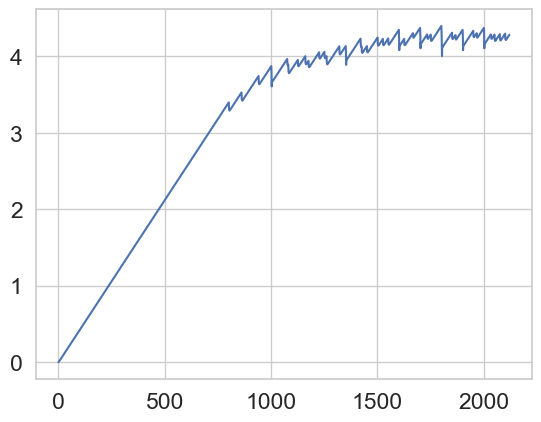

In [229]:
plt.plot(fs)